# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Mounting the Drive

# Importing Libraries

In [195]:
%pip install torchvision
%pip install torch


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [196]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Data Preprocessing

import dataset
resize images etc

### Import Training Target

In [197]:
csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])

label_map = {
    'benign': 0,
    'malignant': 1
}

labels_df['label'] = labels_df['label'].map(label_map)
labels_df.head()

,image_id,label
0,ISIC_0000000,0
1,ISIC_0000001,0
2,ISIC_0000002,1
3,ISIC_0000004,1
4,ISIC_0000006,0


### Import Training Images

In [198]:
image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'
labels_df['file_path'] = labels_df['image_id'].apply(lambda x: f"{image_dir}/{x}.jpg")
labels_df.head()

,image_id,label,file_path
0,ISIC_0000000,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1,ISIC_0000001,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2,ISIC_0000002,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3,ISIC_0000004,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4,ISIC_0000006,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...


### Dataset Class

In [199]:
class ISICDataset(Dataset):
    def __init__(self, labels_df, transform=None):
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert("RGB")
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def characterize(self):
        n_classes = len(self.labels_df['label'].unique())
        n_samples = len(self.labels_df)

        # get min and max size of images
        for idx, row in self.labels_df.iterrows():
            image = Image.open(row['file_path'])
            if idx == 0:
                min_shape = image.size
                max_shape = image.size
            else:
                min_shape = (min(min_shape[0], image.size[0]), min(min_shape[1], image.size[1]))
                max_shape = (max(max_shape[0], image.size[0]), max(max_shape[1], image.size[1]))
        
        # get number of samples per class
        class_counts = self.labels_df['label'].value_counts()
        
        print(f"Dataset has {n_classes} classes")
        print(f"Dataset has {n_samples} samples")
        print(f"Class counts:\n{class_counts}")
        print(f"Min image shape: {min_shape}")
        print(f"Max image shape: {max_shape}")

In [200]:
# Extract mean and std of RGB channels for normalization
def extract_mean_std(labels_df):
    mean = np.zeros(3)
    std = np.zeros(3)
    n_samples = len(labels_df)
    
    for idx, row in labels_df.iterrows():
        img_path = row['file_path']
        img = cv2.imread(img_path) / 255.0
        mean += np.mean(img, axis=(0, 1))
        std += np.std(img, axis=(0, 1))
        
    mean /= n_samples
    std /= n_samples
    
    return mean, std

# Hardcoded ISIC2016 for now
mean, std = [0.56719837, 0.61864448, 0.72383769], [0.15109317, 0.12867224, 0.10518483]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

train_dataset = ISICDataset(labels_df, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

characteristics = train_dataset.characterize()

Dataset has 2 classes
Dataset has 900 samples
Class counts:
0    727
1    173
Name: label, dtype: int64
Min image shape: (576, 542)
Max image shape: (4288, 2848)


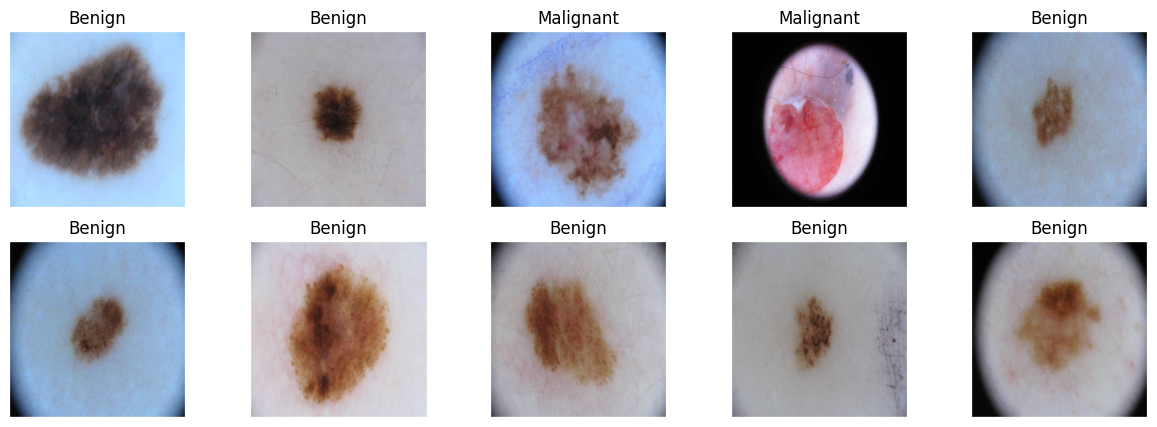

In [201]:
def plot_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 5))
    axes = axes.flatten()
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')
        axes[i].axis('off')
    plt.show()

plot_samples(train_dataset)

# Diffusion-Based Augmentation

# Classification using Vision Transformers